This notebook contains Feature selection with Chi-Square test, Logistic Regression with TFIDF as well as Bidirectional LSTM with gensim to classifies a given tweet into depressive or non-depressive ones.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## Import required libraries

## warnings
import warnings
warnings.filterwarnings("ignore")

## for data
import numpy as np
import pandas as pd

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## TF-IDF 
from sklearn.feature_extraction.text import TfidfVectorizer

## T-Sne
from yellowbrick.text import TSNEVisualizer
from sklearn import manifold

## Train-Test Split
from sklearn.model_selection import train_test_split

## Feature selection
from sklearn import feature_selection

## libraraies for classification
from sklearn.pipeline import Pipeline
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

## for saving model
import pickle

## detokenization
from nltk.tokenize.treebank import TreebankWordDetokenizer

## for word embedding with gensim
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## for word embedding with Spacy
# import spacy
# import en_core_web_lg

## for deep learning
from keras.models import load_model
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import tensorflow as tf
import keras
from keras.layers import Lambda
import tensorflow as tf
from keras.models import model_from_json

## for bert language model
#import transformers

## Loading the dataset:

In [ ]:
df_all = pd.read_csv("/content/drive/MyDrive/NLP/Depression_Detection/data_cleaning/processed_data/processed_data.csv",
                     sep='\t', encoding='utf-8')

In [ ]:
df_all

,text,label,clean_text
0,Open discussion. Between the Transfer Portal a...,1,open discussion transfer portal nil become obs...
1,Plenty of things are changing in my life and t...,1,plenty thing changing life life around one thi...
2,I feel a little hopeless. Anyone else? #hopele...,1,feel little hopeless anyone else
3,"Which is more healthy? Hope, or hopelessness? ...",1,healthy hope hopelessness
4,So someone tell me how do I get over #HOPELESS...,1,someone tell get live world surrounded people ...
...,...,...,...
38904,"@andreaj27 well, cheers. i have a glass of wat...",0,well cheer glass water handy drink cheer
38905,@AndreaJo84 Is that right? You're over in Palm...,0,right palm spring guess see local news still w...
38906,@AndreaKobayashi It's the best cafe in Asakusa...,0,best cafe asakusa tokyo small serf best coffee
38907,@AndreaKoeln heeey! tonight is the night! no s...,0,heeey tonight night sleeping like night loll


## Feature selection

In order to drop some columns and reduce the matrix dimensionality, we can carry out some Feature Selection, the process of selecting a subset of relevant variables. I will proceed as follows:



1.   treat each category as binary (for example, the “depressive” category is 1 for the depressive tweets and 0 for non_depressive);
2.   perform a Chi-Square test to determine whether a feature and the (binary) target are independent;
3.   keep only the features with a certain p-value from the Chi-Square test.

This snippet of code is derived from https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794



In [ ]:
y = y_train
X_names = cv.get_feature_names()
p_value_limit = 0.95
df_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train_tfidf, y==cat)
    df_features = df_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    df_features = df_features.sort_values(["y","score"], 
                    ascending=[True,False])
    df_features = df_features[df_features["score"]>p_value_limit]
X_names = df_features["feature"].unique().tolist()

In [ ]:
print(len(X_names))

688


I reduced the number of features from 20018 to 688 by keeping the most statistically relevant ones. Let’s print some:

In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(df_features[df_features["y"]==cat]))
   print("  . top features:", ",".join(df_features[df_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# 0:
  . selected features: 688
  . top features: anxiety,depression,health,http,mental,thanks,feel,feeling,lol,someone
 
# 1:
  . selected features: 688
  . top features: anxiety,depression,health,http,mental,thanks,feel,feeling,lol,someone
 


## Logistic Regression with TFIDF:

### Spliting data to train and test datasets:

In [ ]:
## split dataset to train and test
X_train, X_test, y_train, y_test = train_test_split(df_all['clean_text'], df_all['label'], test_size=0.3, random_state= 42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16464,), (7056,), (16464,), (7056,))

### TF-IDF 

TF-IDF (term frequency and inverse document frequency):

In [ ]:
## Creating the TF-IDF model
cv = TfidfVectorizer()
cv.fit(X_train.to_list())
dic_vocabulary = cv.vocabulary_

In [ ]:
X_train_tfidf = cv.transform(X_train.to_list())

In [ ]:
X_test_tfidf = cv.transform(X_test.to_list())

In [ ]:
cv.inverse_transform(X_test_tfidf[0])

[array(['much', 'love', 'idol', 'guy'], dtype='<U62')]

In [ ]:
X_train_tfidf.shape

(16464, 20018)

In [ ]:
# ## Adding clean tweets to a list called corpus
# corpus = []
# corpus = [x for x in df_train['clean_text']] 
# # corpus = df_train["clean_text"]

The feature matrix X_train_tfidf has a shape of 16,464 (Number of documents in training) x 20018 (Length of vocabulary) and it’s pretty sparse:

Text(0.5, 1.0, 'Sparse Matrix Sample')

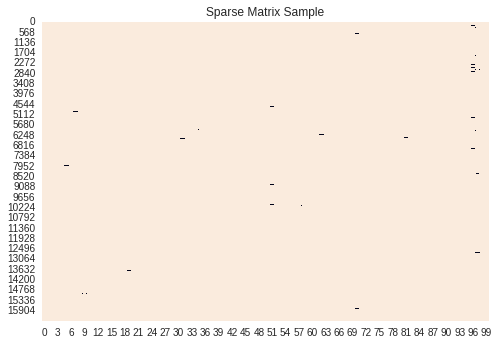

In [ ]:
sns.heatmap(X_train_tfidf.todense()[:,np.random.randint(0,X_train_tfidf.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In order to know the position of a certain word, we can look it up in the vocabulary:

In [ ]:
word = "mental"
dic_vocabulary[word]

11357

Build a scikit-learn pipeline: a sequential application of a list of transformations and a final estimator. Putting the Tf-Idf vectorizer and Logistic Regression classifier in a pipeline allows us to transform and predict test data in just one step.

In [ ]:
# classifier = LogisticRegression(solver='liblinear', penalty='l1')

In [ ]:
# ## pipeline
# model = Pipeline([("vectorizer", cv), 
#                   ("classifier", classifier)])
# ## train classifier
# model["classifier"].fit(X_train, y_train)
# ## test
# predicted = model.predict(X_test)
# predicted_prob = model.predict_proba(X_test)

In [ ]:
# ## creating the instance of the models
lr = LogisticRegression(solver='liblinear', penalty='l1')
## fitting the model
print(lr.fit(X_train_tfidf, y_train.to_list()))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
## Save the Modle to file in the current working directory
LogisticReg = "/content/drive/MyDrive/NLP/Depression_Detection/modeling/model_LogReg.pkl"  

with open(LogisticReg, 'wb') as file:  
    pickle.dump(lr, file)

In [ ]:
## Load the Model back from file
with open(LogisticReg, 'rb') as file:  
    lr = pickle.load(file)

lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
## Test
y_pred_lr = lr.predict(X_test_tfidf)
probs = lr.predict_proba(X_test_tfidf)
classes = np.unique(y_test.to_list())
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Evaluate the performance:

*   **Accuracy:** the fraction of predictions the model got right.
*   **Confusion Matrix:** a summary table that breaks down the number of correct and incorrect predictions by each class.
*   **ROC:** a plot that illustrates the true positive rate against the false positive rate at various threshold settings. The area under the curve (AUC) indicates the probability that the classifier will rank a randomly chosen positive observation higher than a randomly chosen negative one.
*  **Precision:** the fraction of relevant instances among the retrieved instances.
*  **Recall:** the fraction of the total amount of relevant instances that were actually retrieved.



In [ ]:
def conf_matrix_acc(y_true, y_pred):
  ## Plot confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)
  print("=========================================")
  print(f'Accuracy score is : {accuracy_score(y_true, y_pred)}')
  print("=========================================")
  print("Detail:")
  print(skm.classification_report(y_true, y_pred))

In [ ]:
## Plot ROC and precision-recall curve
def roc_precision_auc():
  fig, ax = plt.subplots(nrows=1, ncols=2)
  ## Plot roc
  for i in range(len(classes)):
      fpr, tpr, thresholds = skm.roc_curve(y_test_array[:,i],  
                            probs[:,i])
      ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                skm.auc(fpr, tpr))
                 )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)

  ## Plot precision-recall curve
  for i in range(len(classes)):
    precision, recall, thresholds = skm.precision_recall_curve(
                y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  skm.auc(recall, precision))
              )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()
  #plt.savefig('/content/drive/MyDrive/NLP/Depression_Detection/modeling/ROC_Precision_LR.png')
  plt.savefig('/content/drive/MyDrive/NLP/Depression_Detection/modeling/ROC_Precision_SVM.png')  
  ## AUC score
  print(f'AUC score is : {skm.roc_auc_score(Y_test, probs[:,1])}')

Accuracy score is : 0.8360260770975056
Detail:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      3627
           1       0.85      0.80      0.83      3429

    accuracy                           0.84      7056
   macro avg       0.84      0.84      0.84      7056
weighted avg       0.84      0.84      0.84      7056



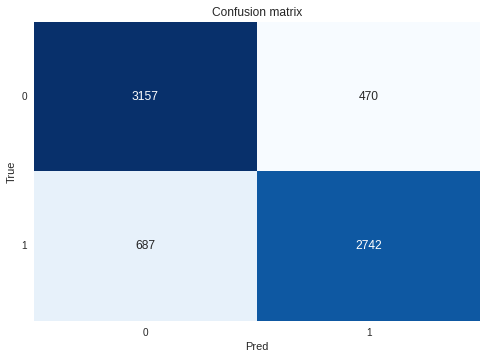

In [ ]:
conf_matrix_acc(y_test.to_list(),y_pred_lr)

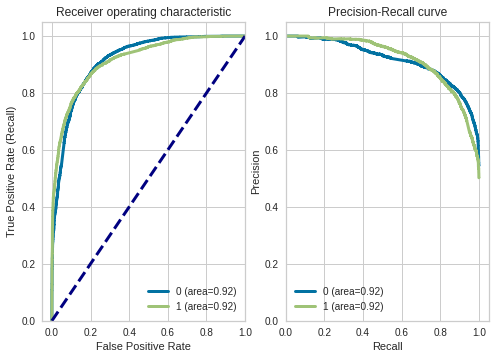

AUC score is : 0.9160498973103044


In [ ]:
roc_precision_auc()

## Bidirectional LSTM:

In Python, you can load a pre-trained Word Embedding model from genism-data like this:


In [ ]:
nlp_pre = gensim_api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


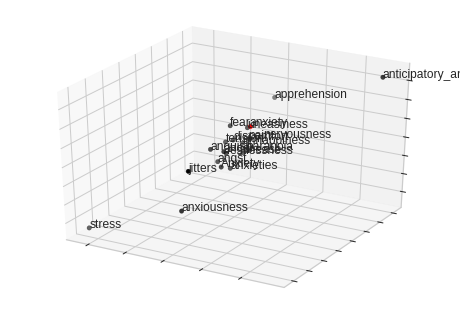

In [ ]:
word = "anxiety"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp_pre.most_similar(word, topn=20)]
X = nlp_pre[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

Instead of using a pre-trained model, I am going to fit my own Word2Vec on the training data corpus with gensim. Before fitting the model, the corpus needs to be transformed into a list of lists of n-grams. In this particular case, I’ll try to capture unigrams (“york”), bigrams (“new york”), and trigrams (“new york city”).

In [ ]:
## split dataset
dtf_train, dtf_test = train_test_split(df_all, test_size=0.3)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [ ]:
corpus = []
corpus = [x for x in dtf_train['clean_text']]

In [ ]:
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = str(string).split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

When fitting the Word2Vec, you need to specify:

* the target size of the word vectors, I’ll use 300;
* the window, or the maximum distance between the current and predicted word within a sentence, I’ll use the mean length of text in the corpus;
* the training algorithm, I’ll use skip-grams (sg=1) as in general it has better results.

In [ ]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

We have our embedding model, so we can select any word from the corpus and transform it into a vector.

In [ ]:
word = "anxiety"
nlp[word].shape

(300,)

We can even use it to visualize a word and its context into a smaller dimensional space (2D or 3D) by applying any dimensionality reduction algorithm (i.e. TSNE).

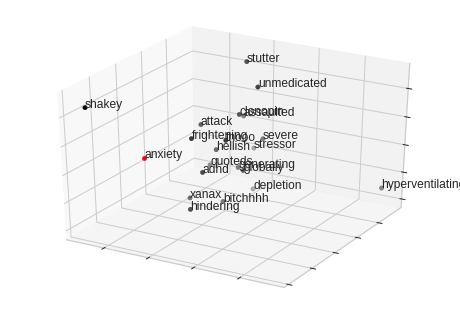

In [ ]:
word = "anxiety"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

The word vectors can be used in a neural network as weights in the follwing procedure:
1. Transform the corpus into padded sequences of word ids to get a feature matrix.
2. Create an embedding matrix so that the vector of the word with id N is located at the Nth row.
3. Build a neural network with an embedding layer that weighs every word in the sequences with the corresponding vector.

**Feature Engineering:** by transforming the same preprocessed corpus (list of lists of n-grams) given to the Word2Vec into a list of sequences using tensorflow/keras:

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=35, padding="post", truncating="post")

In [ ]:
X_train.shape

(16559, 35)

The feature matrix X_train has a shape of 16559 x 35 (Number of sequences x Sequences max length). Let’s visualize it:

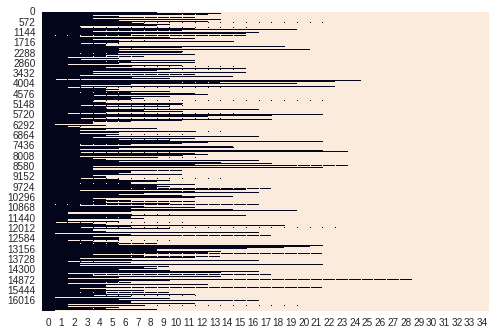

In [ ]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Every text in the corpus is now an id sequence with length 35. For instance, if a text had 20 tokens in it, then the sequence is composed of 20 ids + 15 0s, which is the padding element (while the id for word not in the vocabulary is 1)

Let’s print how a text from the train set has been transformed into a sequence with the padding and the vocabulary.

In [ ]:
i = 8

## list of text: ["I like this", ...]
len_txt = len(dtf_train["clean_text"].iloc[i].split())
print("from: ", dtf_train["clean_text"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["clean_text"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["clean_text"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  start support thread comment feeling let u support hate rn want die one care cope long | len: 16
to:  [  76  114 1330  459   32   46    9  114  128  983   19  349    5   60
  870  115    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0] | len: 35
check:  start  -- idx in vocabulary --> 76
vocabulary:  {'NaN': 1, 'like': 2, 'day': 3, 'love': 4, 'one': 5} ... (padding element, 0)


In [ ]:
corpus = dtf_test["clean_text"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = str(string).split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=35,
             padding="post", truncating="post")

In [ ]:
X_test.shape

(7097, 35)

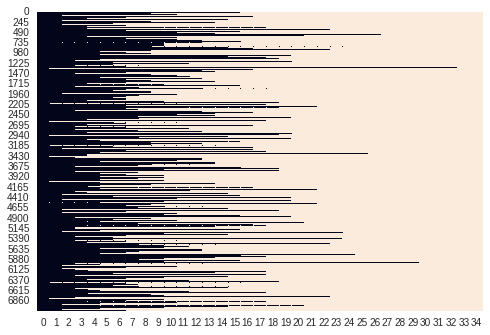

In [ ]:
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

We’ve got our X_train and X_test, now we need to create the embedding matrix that will be used as a weight matrix in the neural network.

In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [ ]:
embeddings.shape

(20151, 300)

That code generates a matrix of shape 20,050 x 300 (Length of vocabulary extracted from the corpus x Vector size). It can be navigated by word id, which can be obtained from the vocabulary.

In [ ]:
word = "anxiety"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 34 |idx
embeddings[idx]: (300,) |vector


### Deep Learning:

It’s finally time to build a deep learning model. I’m going to use the embedding matrix in the first Embedding layer of the neural network that I will build and train to classify the news. Each id in the input sequence will be used as the index to access the embedding matrix. The output of this Embedding layer will be a 2D matrix with a word vector for each word id in the input sequence (Sequence length x Vector size). Let’s use the sentence “I like this article” as an example:

My neural network shall be structured as follows:

* An Embedding layer that takes the sequences as input and the word vectors as weights, just as described before.

* A simple Attention layer that won’t affect the predictions but it’s going to capture the weights of each instance and allow us to build a nice explainer (it isn't necessary for the predictions, just for the explainability, so you can skip it).

* Two layers of Bidirectional LSTM to model the order of words in a sequence in both directions.

* Two final dense layers that will predict the probability of each category.

In [ ]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(35,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=35, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=35)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=35, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=35, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(1, activation='sigmoid')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 300)      6045300     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 35)      0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 35)      1260        permute[0][0]                    
______________________________________________________________________________________________

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=30, shuffle=True, verbose=0, 
                     validation_split=0.3)

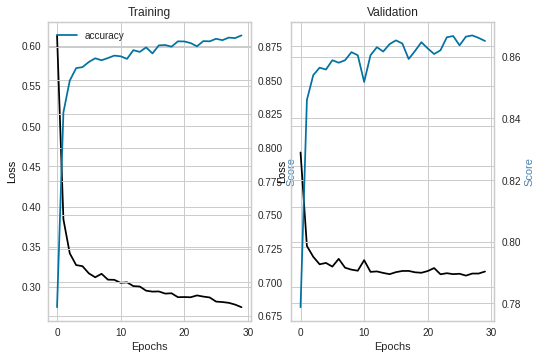

In [ ]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.savefig('/content/drive/MyDrive/NLP/Depression_Detection/modeling/loss_accuracy_LSTM_3.png')
plt.show()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/NLP/Depression_Detection/modeling/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/NLP/Depression_Detection/modeling/model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
loaded_model = model_from_json(open("/content/drive/MyDrive/NLP/Depression_Detection/modeling/model.json", "r").read(),
                              custom_objects={'tf': tf})
json_file.close() 
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/NLP/Depression_Detection/modeling/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
labels_pred = model.predict(X_test)
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(y_test, labels_pred)
classes = np.unique(y_test)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 82.30%


In [ ]:
def conf_matrix_acc2(y_true, y_pred):
  ## Plot confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)
  print("=========================================")
  print(f'Accuracy score is : {accuracy_score(y_true, y_pred)}')
  print("=========================================")
  print("Detail:")
  print(skm.classification_report(y_test, y_pred))

Accuracy score is : 0.8230238128786811
Detail:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      3632
           1       0.87      0.75      0.80      3465

    accuracy                           0.82      7097
   macro avg       0.83      0.82      0.82      7097
weighted avg       0.83      0.82      0.82      7097



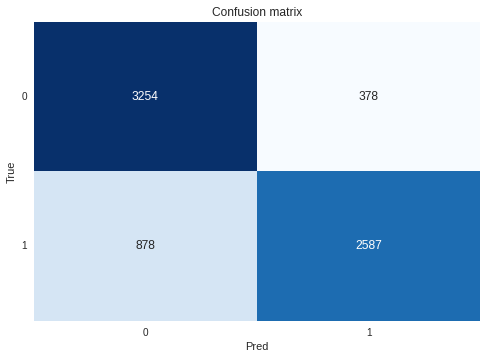

In [ ]:
conf_matrix_acc2(y_test, labels_pred)

In [ ]:
# classes = np.unique(y_test)
# y_test_array = pd.get_dummies(y_test, drop_first=False).values
# predicted_prob = model.predict_on_batch(X_test)

In [ ]:
# ## Plot ROC and precision-recall curve
# def roc_precision_auc2():
#   fig, ax = plt.subplots(nrows=1, ncols=2)
#   ## Plot roc
#   for i in range(len(classes)):
#       fpr, tpr, thresholds = skm.roc_curve(y_test_array[:,i],  
#                             predicted_prob[:,i])
#       ax[0].plot(fpr, tpr, lw=3, 
#                 label='{0} (area={1:0.2f})'.format(classes[i], 
#                                 skm.auc(fpr, tpr))
#                  )
#   ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
#   ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
#             xlabel='False Positive Rate', 
#             ylabel="True Positive Rate (Recall)", 
#             title="Receiver operating characteristic")
#   ax[0].legend(loc="lower right")
#   ax[0].grid(True)

#   ## Plot precision-recall curve
#   for i in range(len(classes)):
#     precision, recall, thresholds = skm.precision_recall_curve(
#                 y_test_array[:,i], probs[:,i])
#     ax[1].plot(recall, precision, lw=3, 
#                label='{0} (area={1:0.2f})'.format(classes[i], 
#                                   skm.auc(recall, precision))
#               )
#   ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
#             ylabel="Precision", title="Precision-Recall curve")
#   ax[1].legend(loc="best")
#   ax[1].grid(True)
#   plt.show()
#   #plt.savefig('/content/drive/MyDrive/NLP/Depression_Detection/modeling/ROC_Precision_LR.png')
#   #plt.savefig('/content/drive/MyDrive/NLP/Depression_Detection/modeling/ROC_Precision_LSTM.png')  
#   ## AUC score
#   print(f'AUC score is : {skm.roc_auc_score(y_test, probs[:,1])}')